In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from tqdm import tqdm
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from torch import nn, optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import torch

df = pd.read_csv('UpdatedMatches.csv')
data = []

C:\Users\herath\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='result', ylabel='count'>

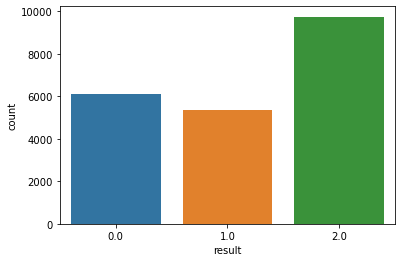

In [2]:
df['season'].replace({'2008/2009':2008, '2009/2010':2009, '2010/2011':2010, '2011/2012':2011, '2012/2013':2012, '2013/2014':2013, '2014/2015':2014, '2015/2016':2015 },inplace=True)

df["result"] = np.nan
for index, row in df.iterrows():
    if df.loc[index,'home_team_goal'] == df.loc[index,'away_team_goal']:
        df.loc[index,'result'] = 1
    if df.loc[index,'home_team_goal'] > df.loc[index,'away_team_goal']:
        df.loc[index,'result'] = 2
    if df.loc[index,'home_team_goal'] < df.loc[index,'away_team_goal']:
        df.loc[index,'result'] = 0
        
sns.countplot(df.result)


In [3]:
df.result.value_counts()/df.shape[0]

2.0    0.459098
0.0    0.288525
1.0    0.252377
Name: result, dtype: float64

In [7]:
from tqdm import tqdm

def teamfunction( df ):
    for index, row in tqdm(df.iterrows()):
        
        home_team = []
        home_team.append(df.loc[index,'buildUpPlaySpeed_home_team'])
        home_team.append(df.loc[index,'buildUpPlayDribbling_home_team'])
        home_team.append(df.loc[index,'buildUpPlayPassing_home_team'])
        home_team.append(df.loc[index,'chanceCreationPassing_home_team'])
        home_team.append(df.loc[index,'chanceCreationCrossing_home_team'])
        home_team.append(df.loc[index,'chanceCreationShooting_home_team'])
        home_team.append(df.loc[index,'defencePressure_home_team'])
        home_team.append(df.loc[index,'defenceAggression_home_team'])
        home_team.append(df.loc[index,'defenceTeamWidth_home_team'])


        away_team = []
        away_team.append(df.loc[index,'buildUpPlaySpeed_away_team'])
        away_team.append(df.loc[index,'buildUpPlayDribbling_away_team'])
        away_team.append(df.loc[index,'buildUpPlayPassing_away_team'])
        away_team.append(df.loc[index,'chanceCreationPassing_away_team'])
        away_team.append(df.loc[index,'chanceCreationCrossing_away_team'])
        away_team.append(df.loc[index,'chanceCreationShooting_away_team'])
        away_team.append(df.loc[index,'defencePressure_away_team'])
        away_team.append(df.loc[index,'defenceAggression_away_team'])
        away_team.append(df.loc[index,'defenceTeamWidth_away_team'])


        team_matrix = []
        for i in range(9):          
            m =[]
            for j in range(9):
                m.append(home_team[i]-away_team[j])
            team_matrix.append(m)

        team_details.append(team_matrix)


In [5]:
X = df.drop(['result','date', 'home_team_goal','away_team_goal'], axis=1)
y = df[['result']]
RANDOM_SEED =42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [6]:
y_train.result.value_counts()/y_train.shape[0]

2.0    0.458637
0.0    0.290715
1.0    0.250647
Name: result, dtype: float64

In [8]:
team_details = []
teamfunction( X_train )
team_train_data = team_details
Team_Train = torch.Tensor(np.array(team_train_data))

16996it [00:18, 931.55it/s] 


In [9]:
Team_Train.size()

torch.Size([16996, 9, 9])

In [10]:
Team_Train.type()

'torch.FloatTensor'

In [11]:
team_details = []
teamfunction( X_test )
team_test_data = team_details
Team_Test = torch.Tensor(np.array(team_test_data))

4250it [00:04, 865.17it/s]


In [12]:
Team_Test.size()

torch.Size([4250, 9, 9])

In [13]:
Team_Test.type()

'torch.FloatTensor'

In [14]:
y_train = torch.squeeze(torch.LongTensor(np.array(y_train)))

In [15]:
y_train.size()

torch.Size([16996])

In [16]:
y_train.type()

'torch.LongTensor'

In [17]:
y_test = torch.squeeze(torch.LongTensor(np.array(y_test)))

In [19]:
y_test.size()

torch.Size([4250])

In [20]:
y_test.type()

'torch.LongTensor'

In [26]:
Team_Train = torch.flatten(Team_Train, start_dim=1)
Team_Test = torch.flatten(Team_Test, start_dim=1)

In [27]:
Team_Train.size()

torch.Size([16996, 81])

In [35]:
Team_Test.size()

torch.Size([4250, 81])

In [36]:
import torch.utils.data as data_utils

train = data_utils.TensorDataset(Team_Train, y_train)
train_loader = data_utils.DataLoader(train, batch_size=50, shuffle=True)

test = data_utils.TensorDataset(Team_Test, y_test)
test_loader = data_utils.DataLoader(test, batch_size=50, shuffle=True)

In [37]:
import torch
from torch import nn, optim
import torch.nn.functional as F

#building neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(81,27)
        self.fc2 = nn.Linear(27,9)
        self.fc3 = nn.Linear(9,3)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.softmax(self.fc3(x), dim = 1)

In [38]:
model = Net()

In [39]:
#Doing it on GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Team_Train = Team_Train.to(device)
Team_Test = Team_Test.to(device)

y_train = y_train.to(device)
y_test = y_test.to(device)

model = model.to(device)
criterion = criterion.to(device)

In [40]:
optimizer = optim.SGD(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [43]:
epochs = 100
train_loss, val_loss = [], []
accuracy_total_train, accuracy_total_val = [], []

for epoch in range(epochs):
   
    total_train_loss = 0
    total_val_loss = 0

    model.train()
    
    total = 0
    # training our model
    for i, (x, y) in enumerate(train_loader):

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward(retain_graph=True)        
        optimizer.step()
        total_train_loss += loss.item()

        for i, p in enumerate(y_pred):
            if y[i] == torch.max(p.data, 0)[1]:
                total = total + 1
                
    accuracy_train = total / len(train)
    accuracy_total_train.append(accuracy_train)

    total_train_loss = total_train_loss / (i + 1)
    train_loss.append(total_train_loss)
    
    # validating our model
    model.eval()
    total = 0
    for i, (x, y) in enumerate(test_loader):

        y_pred = model(x)
        loss = criterion(y_pred, y)                
        total_val_loss += loss.item()
        
        for i, p in enumerate(y_pred):
            if y[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy_val = total / len(test)
    accuracy_total_val.append(accuracy_val)

    total_val_loss = total_val_loss / (i + 1)
    val_loss.append(total_val_loss)
    
    if epoch % 1 == 0:
        print("Epoch: {}/{}  ".format(epoch, epochs),
            "Training loss: {:.4f}  ".format(total_train_loss),
            "Testing loss: {:.4f}  ".format(total_val_loss),
            "Train accuracy: {:.4f}  ".format(accuracy_train),
            "Test accuracy: {:.4f}  ".format(accuracy_val))

Epoch: 0/100   Training loss: 7.7094   Testing loss: 1.7942   Train accuracy: 0.4769   Test accuracy: 0.4593  
Epoch: 1/100   Training loss: 7.7082   Testing loss: 1.7947   Train accuracy: 0.4773   Test accuracy: 0.4584  
Epoch: 2/100   Training loss: 7.7069   Testing loss: 1.7947   Train accuracy: 0.4776   Test accuracy: 0.4591  
Epoch: 3/100   Training loss: 7.7064   Testing loss: 1.7948   Train accuracy: 0.4779   Test accuracy: 0.4569  
Epoch: 4/100   Training loss: 7.7056   Testing loss: 1.7951   Train accuracy: 0.4775   Test accuracy: 0.4560  
Epoch: 5/100   Training loss: 7.7039   Testing loss: 1.7936   Train accuracy: 0.4796   Test accuracy: 0.4600  
Epoch: 6/100   Training loss: 7.7033   Testing loss: 1.7943   Train accuracy: 0.4789   Test accuracy: 0.4595  
Epoch: 7/100   Training loss: 7.7020   Testing loss: 1.7942   Train accuracy: 0.4789   Test accuracy: 0.4591  
Epoch: 8/100   Training loss: 7.7015   Testing loss: 1.7944   Train accuracy: 0.4792   Test accuracy: 0.4558  
E

Epoch: 74/100   Training loss: 7.6509   Testing loss: 1.7918   Train accuracy: 0.4887   Test accuracy: 0.4621  
Epoch: 75/100   Training loss: 7.6505   Testing loss: 1.7915   Train accuracy: 0.4901   Test accuracy: 0.4616  
Epoch: 76/100   Training loss: 7.6492   Testing loss: 1.7919   Train accuracy: 0.4896   Test accuracy: 0.4612  
Epoch: 77/100   Training loss: 7.6492   Testing loss: 1.7922   Train accuracy: 0.4904   Test accuracy: 0.4616  
Epoch: 78/100   Training loss: 7.6482   Testing loss: 1.7915   Train accuracy: 0.4888   Test accuracy: 0.4612  
Epoch: 79/100   Training loss: 7.6480   Testing loss: 1.7918   Train accuracy: 0.4889   Test accuracy: 0.4621  
Epoch: 80/100   Training loss: 7.6474   Testing loss: 1.7910   Train accuracy: 0.4902   Test accuracy: 0.4633  
Epoch: 81/100   Training loss: 7.6456   Testing loss: 1.7930   Train accuracy: 0.4889   Test accuracy: 0.4609  
Epoch: 82/100   Training loss: 7.6462   Testing loss: 1.7914   Train accuracy: 0.4892   Test accuracy: 0

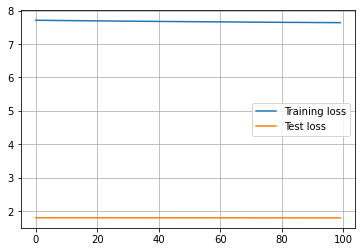

In [44]:
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Test loss')
plt.legend()
plt.grid()

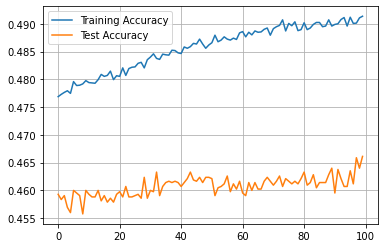

In [45]:
plt.plot(accuracy_total_train, label='Training Accuracy')
plt.plot(accuracy_total_val, label='Test Accuracy')
plt.legend()
plt.grid()

In [46]:
#saving the model

MODEL_PATH = 'teammodel.pth'
torch.save(model, MODEL_PATH)

In [47]:
model = torch.load(MODEL_PATH)

In [49]:
#Evaluation
classes = ['Loss','Draw','Win']
predict_list = []
y_pred = model(Team_Test)

for i, p in enumerate(y_pred):
    y_pred = torch.max(p.data, 0)[1]
    predict_list.append(y_pred)
stacked_tensor = torch.stack(predict_list)
y_test = y_test.cpu()

In [50]:
print(classification_report(y_test, stacked_tensor, target_names=classes))

              precision    recall  f1-score   support

        Loss       0.39      0.24      0.30      1189
        Draw       0.25      0.01      0.02      1102
         Win       0.48      0.86      0.62      1959

    accuracy                           0.47      4250
   macro avg       0.38      0.37      0.31      4250
weighted avg       0.40      0.47      0.37      4250



Text(0.5, 15.0, 'Predicted label')

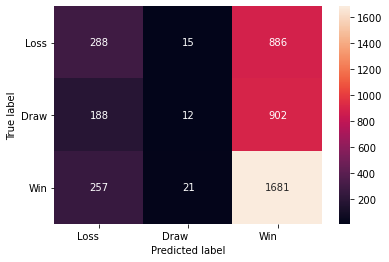

In [51]:
cm = confusion_matrix(y_test, stacked_tensor)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=0, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')